## 1) Importing Libraries

In [5]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense


## 2) Data Loading

In [6]:
def load_images_from_folder(folder):
    images = []
    names = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            names.append(filename)
    return images,names

In [7]:
train_data, train_label = load_images_from_folder(r'/kaggle/input/crack-dent-dataset/Aerothon/2_crop/Train_cropped')
target = pd.read_csv(r'/kaggle/input/crack-dent-dataset/Aerothon/3_resizing/train_label_match.csv')

In [8]:
len(train_data)

9499

## 3) Data Preprocessing

In [9]:
target['defect'].value_counts()

defect
crack    5820
dent     3679
Name: count, dtype: int64

In [19]:
target

,Image_name,defect
0,02__Crack_in_Between_Rotor_Seating_Areas-_Appr...,crack
1,02__Crack_in_Between_Rotor_Seating_Areas-_Appr...,crack
2,02__Crack_in_Between_Rotor_Seating_Areas-_Appr...,crack
3,02__Crack_in_Between_Rotor_Seating_Areas-_Appr...,crack
4,02__Crack_in_Between_Rotor_Seating_Areas-_Appr...,crack
...,...,...
9494,West-Atlantic-Boeing-737-Suffers-Hard-Landing-...,dent
9495,West-Atlantic-Boeing-737-Suffers-Hard-Landing-...,dent
9496,West-Atlantic-Boeing-737-Suffers-Hard-Landing-...,dent
9497,West-Atlantic-Boeing-737-Suffers-Hard-Landing-...,dent


In [10]:
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (128,128)) # Resizing the image to 224x224 dimention
    image /= 255.0
    image = np.expand_dims(image, axis=0)
    
    return (image)

In [11]:
for i in range(len(train_data)):
    train_data[i]=scale_resize_image(train_data[i])
    

In [12]:
ml_data = np.empty([len(train_data),128,128,3])

In [13]:
for i in range(len(train_data)):
    ml_data[i,:,:,:] = train_data[i]

In [14]:
from sklearn.preprocessing  import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(target[['defect']])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.categories_[0])
print(onehot_df.value_counts)

<bound method DataFrame.value_counts of       crack  dent
0       1.0   0.0
1       1.0   0.0
2       1.0   0.0
3       1.0   0.0
4       1.0   0.0
...     ...   ...
9494    0.0   1.0
9495    0.0   1.0
9496    0.0   1.0
9497    0.0   1.0
9498    0.0   1.0

[9499 rows x 2 columns]>


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 4) Model Architecture

In [30]:
def create_custom_cnn(input_shape=(128, 128, 3)):
    model = Sequential()
    model.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(12, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    
    return model

# Create the model
model = create_custom_cnn(input_shape=(128, 128, 3))
model.summary()

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_9 (Conv2D)           (None, 128, 128, 3)       84        

                                                                 

 batch_normalization_9 (Bat  (None, 128, 128, 3)       12        

 chNormalization)                                                

                                                                 

 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 3)         0         

 g2D)                                                            

                                                                 

 dropout_12 (Dropout)        (None, 64, 64, 3)         0         

                                                                 

 conv2d_10 (Conv2D)          (None, 64, 64, 12)        336       

                                                                 

 batch_normalization_10 (Ba  (None, 64

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

## 5) Model Training

In [35]:
# Model training
history = model.fit(
    ml_data, 
    onehot_df,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1    
)


Epoch 1/200

268/268 [==============================] - 38s 136ms/step - loss: 0.9014 - accuracy: 0.5985 - val_loss: 1.1312 - val_accuracy: 0.2916

Epoch 2/200

268/268 [==============================] - 34s 127ms/step - loss: 0.6492 - accuracy: 0.6354 - val_loss: 1.0105 - val_accuracy: 0.3189

Epoch 3/200

268/268 [==============================] - 35s 129ms/step - loss: 0.6279 - accuracy: 0.6561 - val_loss: 0.8738 - val_accuracy: 0.6189

Epoch 4/200

268/268 [==============================] - 36s 135ms/step - loss: 0.6157 - accuracy: 0.6630 - val_loss: 0.8996 - val_accuracy: 0.6516

Epoch 5/200

268/268 [==============================] - 37s 137ms/step - loss: 0.6054 - accuracy: 0.6708 - val_loss: 0.9286 - val_accuracy: 0.6589

Epoch 6/200

268/268 [==============================] - 41s 155ms/step - loss: 0.5992 - accuracy: 0.6722 - val_loss: 0.9633 - val_accuracy: 0.6705

Epoch 7/200

268/268 [==============================] - 37s 135ms/step - loss: 0.5908 - accuracy: 0.6860 - val_l

In [36]:
# Model training
history = model.fit(
    ml_data, 
    onehot_df,
    epochs=1,
    batch_size=32,
    validation_split=0.1,
    verbose=1    
)


268/268 [==============================] - 33s 122ms/step - loss: 0.2149 - accuracy: 0.9060 - val_loss: 1.5673 - val_accuracy: 0.6505


## 6) Model Testing

In [30]:
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (128,128))
    image=image/255.0
    image = np.expand_dims(image, axis=0)
    return (image)

In [17]:
model=load_model('/kaggle/input/model-1file/defect_aerothon_final.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [47]:
img=cv2.imread(r'/kaggle/input/crack-dent-dataset/Aerothon/2_crop/Test_cropped/SDR-510018110_jpg.rf.9e1efa0e47c9d27f192ef9fcd33c52f1_139.jpg')

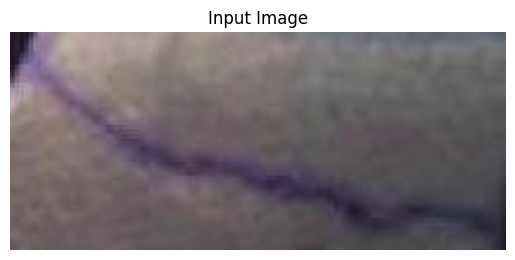

In [48]:
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')  # Hide axes
plt.show()

In [49]:
img=scale_resize_image(img)

In [50]:
pred=model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [51]:
output_map=['crack','dent']

In [52]:
print("The area shown in image has a: ",output_map[np.argmax(pred)])

The area shown in image has a:  crack
